In [1]:
print('hello world')

hello world


In [2]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
uniq=list(set(c for w in words for c in w))
uniq= uniq + ['.']
vocab=sorted(uniq)
stoi = {c:i for i,c in enumerate(vocab) }
itos = {i:s for s,i in stoi.items()}

In [5]:
vocab_len=len(vocab)
vocab_len

27

In [6]:
block_size=3
X,Y=[],[]
for w in words[:5]:
  context = [0]*block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    print(f'{"".join(itos[c] for c in context)} --> {ch}')
    context = context[1:] + [stoi[ch]]

X=torch.tensor(X)
Y=torch.tensor(Y)

... --> e
..e --> m
.em --> m
emm --> a
mma --> .
... --> o
..o --> l
.ol --> i
oli --> v
liv --> i
ivi --> a
via --> .
... --> a
..a --> v
.av --> a
ava --> .
... --> i
..i --> s
.is --> a
isa --> b
sab --> e
abe --> l
bel --> l
ell --> a
lla --> .
... --> s
..s --> o
.so --> p
sop --> h
oph --> i
phi --> a
hia --> .


In [7]:
X.shape,Y.shape


(torch.Size([32, 3]), torch.Size([32]))

In [8]:
n_emb=2
C=torch.randn((vocab_len, 2))
C.shape

torch.Size([27, 2])

In [9]:
emb=C[X]
print(emb.shape)

emb[3], X[3], C[[5,13,13]]

torch.Size([32, 3, 2])


(tensor([[-0.2908, -0.3929],
         [-0.8274,  0.2596],
         [-0.8274,  0.2596]]),
 tensor([ 5, 13, 13]),
 tensor([[-0.2908, -0.3929],
         [-0.8274,  0.2596],
         [-0.8274,  0.2596]]))

In [10]:
n_neurons=100
W1 = torch.randn((block_size*n_emb, n_neurons))
b1 = torch.randn(n_neurons)
W1.shape, b1.shape



(torch.Size([6, 100]), torch.Size([100]))

In [11]:
W2 = torch.randn((n_neurons, vocab_len))
b2 = torch.randn(vocab_len)
W2.shape, b2.shape

(torch.Size([100, 27]), torch.Size([27]))

In [12]:
hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
h = torch.tanh(hpreact)
logits = h @ W2 + b2
probs =  F.softmax(logits, 1)

In [13]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.5956)

In [77]:
# train prep
n_emb=10
n_neurons=100 # n_hidden
block_size=6

X,Y=[],[]
for w in words:
  context = [0]*block_size
  for ch in w+'.':
    X.append(context)
    Y.append(stoi[ch])
    #print(f'{"".join(itos[c] for c in context)} --> {ch}')
    context = context[1:] + [stoi[ch]]

X=torch.tensor(X)
Y=torch.tensor(Y)

g = torch.Generator().manual_seed(782361)

# init
C  = torch.randn((vocab_len, n_emb),            generator=g)
W1 = torch.randn((block_size*n_emb, n_neurons), generator=g) * ((5/3)/((block_size*n_emb)**0.5))
b1 = torch.randn(n_neurons,                     generator=g) * 0.001
W2 = torch.randn((n_neurons, vocab_len),        generator=g) * 0.01
b2 = torch.randn(vocab_len,                     generator=g) * 0.001
bngain = torch.ones((1,n_neurons))
bnbias = torch.zeros((1,n_neurons))

# check why mean are zeros and std are ones
bnmean_running = torch.zeros((1, n_neurons))
bnstd_running = torch.ones((1, n_neurons))

parameters = [C,W1,b1,W2,b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

In [78]:
((5/3)/((block_size*n_emb)**0.5))

0.21516574145596762

In [79]:
X.shape, Y.shape

(torch.Size([228146, 6]), torch.Size([228146]))

In [80]:
lossi = []

In [81]:
# train
lr = 0.1

for _ in range(10_000):
  # minibatch
  batch = torch.randint(0, X.shape[0], (64,), generator=g)

  # forward pass
  emb=C[X[batch]]
  hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  # notes: read again, check what happens to the result of hpreact after below operation
  hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[batch])
  
  # clear grads
  for p in parameters:
    p.grad = None
  # recompute grads
  loss.backward()
  # update
  for p in parameters:
    p.data += -lr * p.grad

  lossi.append(loss.item())
loss

tensor(1.8706, grad_fn=<NllLossBackward0>)

In [82]:
hpreact.shape

torch.Size([64, 100])

In [83]:
hpreact.mean(0).shape

torch.Size([100])

(array([303., 226., 219., 162., 165., 143., 147., 111., 131., 113., 119.,
        134., 109., 128.,  82., 110.,  87., 144.,  59.,  56.,  98.,  97.,
         89.,  71.,  86.,  78.,  65.,  76.,  74.,  96.,  83.,  58.,  72.,
        100., 138., 106., 107., 115., 191.,  98., 106., 123., 136., 142.,
        173., 149., 186., 203., 226., 310.]),
 array([-9.99913275e-01, -9.59917490e-01, -9.19921706e-01, -8.79925921e-01,
        -8.39930136e-01, -7.99934351e-01, -7.59938567e-01, -7.19942782e-01,
        -6.79946997e-01, -6.39951212e-01, -5.99955428e-01, -5.59959643e-01,
        -5.19963858e-01, -4.79968073e-01, -4.39972289e-01, -3.99976504e-01,
        -3.59980719e-01, -3.19984934e-01, -2.79989150e-01, -2.39993365e-01,
        -1.99997580e-01, -1.60001795e-01, -1.20006011e-01, -8.00102258e-02,
        -4.00144410e-02, -1.86562538e-05,  3.99771285e-02,  7.99729133e-02,
         1.19968698e-01,  1.59964483e-01,  1.99960268e-01,  2.39956052e-01,
         2.79951837e-01,  3.19947622e-01,  3.59943

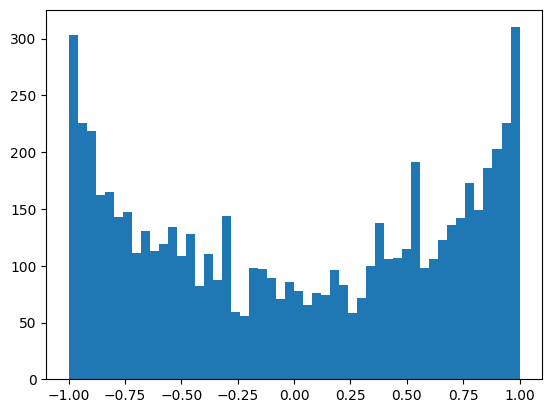

In [84]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   0.,   0.,   0.,   2.,   1.,   4.,   8.,  10.,  11.,  14.,
         31.,  41.,  46.,  81., 100., 108., 185., 211., 246., 309., 346.,
        429., 449., 357., 400., 358., 448., 456., 345., 326., 238., 216.,
        158., 126.,  83.,  81.,  58.,  40.,  24.,  20.,  10.,   6.,   7.,
          5.,   2.,   1.,   1.,   0.,   1.]),
 array([-5.02282572, -4.82548983, -4.62815393, -4.43081804, -4.23348215,
        -4.03614626, -3.83881037, -3.64147448, -3.44413858, -3.24680269,
        -3.0494668 , -2.85213091, -2.65479502, -2.45745913, -2.26012323,
        -2.06278734, -1.86545145, -1.66811556, -1.47077967, -1.27344378,
        -1.07610788, -0.87877199, -0.6814361 , -0.48410021, -0.28676432,
        -0.08942842,  0.10790747,  0.30524336,  0.50257925,  0.69991514,
         0.89725103,  1.09458693,  1.29192282,  1.48925871,  1.6865946 ,
         1.88393049,  2.08126638,  2.27860228,  2.47593817,  2.67327406,
         2.87060995,  3.06794584,  3.26528173,  3.46261763,  3.65995352,
 

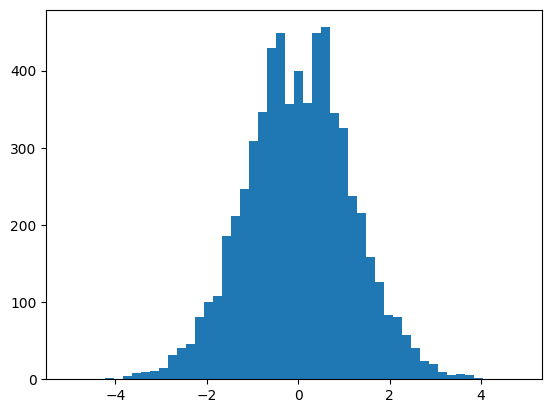

In [85]:
plt.hist(hpreact.view(-1).tolist(), 50)

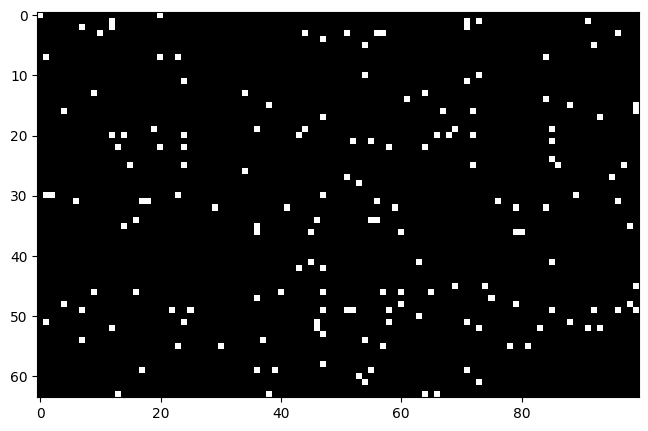

In [86]:
plt.figure(figsize=(10,5))
plt.imshow(h.abs() > 0.99, cmap='gray')

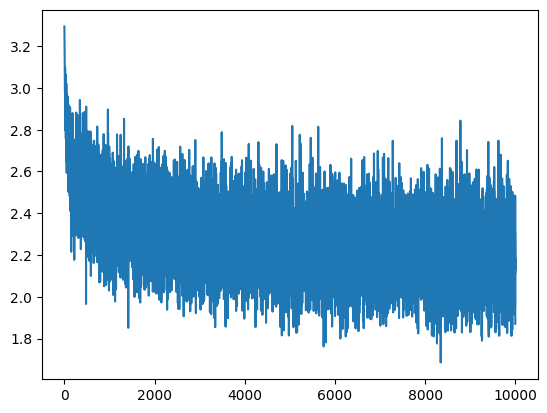

In [87]:
plt.plot(lossi)

In [88]:
# init estimate loss
-torch.tensor(1/vocab_len).log()

tensor(3.2958)

(array([   3.,   34.,  213.,  850., 1890., 2007., 1064.,  286.,   48.,
           5.]),
 array([-5.02282572, -4.03614626, -3.0494668 , -2.06278734, -1.07610788,
        -0.08942842,  0.89725103,  1.88393049,  2.87060995,  3.85728941,
         4.84396887]),
 <BarContainer object of 10 artists>)

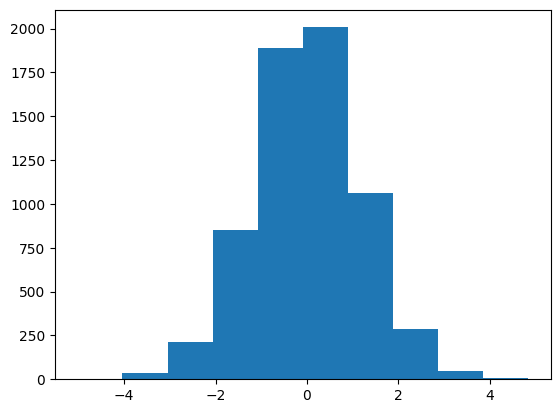

In [89]:
plt.hist(hpreact.view(-1).tolist())


(array([ 17., 120., 354., 446., 427., 205.,  97.,  53.,   7.,   2.]),
 array([-4.75515938, -3.53803754, -2.3209157 , -1.10379386,  0.11332798,
         1.33044982,  2.54757166,  3.7646935 ,  4.98181534,  6.19893718,
         7.41605902]),
 <BarContainer object of 10 artists>)

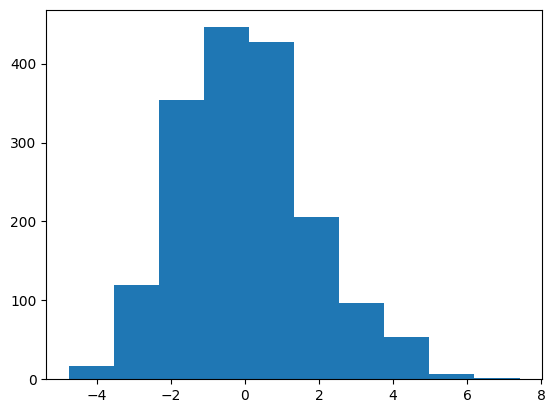

In [90]:
plt.hist(logits.view(-1).tolist())

In [92]:
# inference
out=[]
for i in range(10):
  out.append([])
  context = [0] * block_size
  while True:
    # forward pass
    emb = C[context]
    hpreact = emb.view(-1, block_size*n_emb) @ W1 + b1
    hpreact = ((hpreact - bnmean_running) / bnstd_running)
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, 1)
    hit = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out[i].append(hit)
    if hit == 0:
      break
    context = context[1:] + [hit]
for o in out:
  print(''.join(itos[x] for x in o))

bbeniir.
joha.
lassich.
shawum.
toran.
gadhincee.
noif.
bbrand.
mamarie.
khtaleona.
